5.2 convNet 맛보기 - fashion mnist dataset example


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
train_dataset = torchvision.datasets.FashionMNIST("./dl_pytorch/chap05/data",download=True,transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("./dl_pytorch/chap05/data",download=True,transform=transforms.Compose([transforms.ToTensor()]))

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=100)

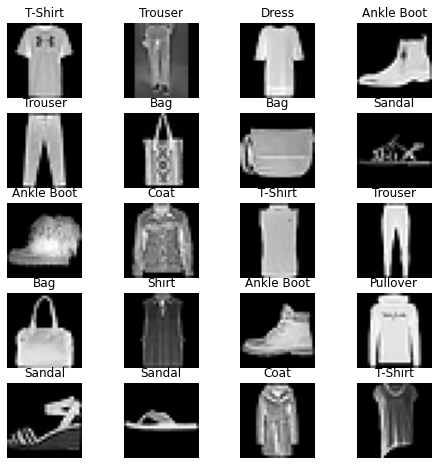

In [6]:
labels_map = {0:'T-Shirt',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle Boot'}
fig=plt.figure(figsize=(8,8));
columns=4;
rows=5;
for i in range(1,columns*rows+1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows,columns,i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img,cmap='gray')
plt.show()

In [7]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN,self).__init__()
        self.fc1 = nn.Linear(in_features=784,out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2=nn.Linear(in_features=256,out_features=128)
        self.fc3=nn.Linear(in_features=128,out_features=10)
    def forward(self,input_data):
        out=input_data.view(-1,784)
        out=F.relu(self.fc1(out))
        out=self.drop(out)
        out=F.relu(self.fc2(out))
        out=self.fc3(out)
        return out

In [8]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
num_epochs = 5
count=0
loss_list=[]
iteration_list=[]
accuracy_list =[]
predictions_list=[]
labels_list=[]
for epoch in range(num_epochs):
    for images,labels in train_loader:
        images,labels = images.to(device),labels.to(device)

        train=Variable(images.view(100,1,28,28))
        labels=Variable(labels)

        outputs=model(train)
        loss=criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count+=1

        if not(count%50):
            total=0
            correct=0
            for images,labels in test_loader:
                images,labels = images.to(device),labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs=model(test)
                predictions=torch.max(outputs,1)[1].to(device)
                predictions_list.append(predictions)
                correct+=(predictions==labels).sum()
                total+=len(labels)
            accuracy=correct*100/total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not count%500:
            print("Iteration:{},Loss:{},Accuracy{}%".format(count,loss.data,accuracy))

Iteration:500,Loss:0.623262882232666,Accuracy84.59833526611328%
Iteration:1000,Loss:0.4940999746322632,Accuracy85.91333770751953%
Iteration:1500,Loss:0.37392696738243103,Accuracy85.95833587646484%
Iteration:2000,Loss:0.40406617522239685,Accuracy87.43000030517578%
Iteration:2500,Loss:0.2373867630958557,Accuracy87.85166931152344%
Iteration:3000,Loss:0.27823784947395325,Accuracy88.38833618164062%


In [10]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layer2=nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1=nn.Linear(in_features=64*6*6,out_features=600)
        self.drop=nn.Dropout2d(0.25)
        self.fc2=nn.Linear(in_features=600,out_features=120)
        self.fc3=nn.Linear(in_features=120,out_features=10)
    def forward(self,x):
        out = self.layer1(x)
        out=self.layer2(out)
        out=out.view(out.size(0),-1)
        out=self.fc1(out)
        out=self.drop(out)
        out=self.fc2(out)
        out=self.fc3(out)
        return out

In [11]:
learning_rate = 0.001
model= FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [12]:
num_epochs = 5
count=0
loss_list=[]
iteration_list=[]
accuracy_list =[]
predictions_list=[]
labels_list=[]
for epoch in range(num_epochs):
    for images,labels in train_loader:
        images,labels = images.to(device),labels.to(device)

        train=Variable(images.view(100,1,28,28))
        labels=Variable(labels)

        outputs=model(train)
        loss=criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count+=1

        if not(count%50):
            total=0
            correct=0
            for images,labels in test_loader:
                images,labels = images.to(device),labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs=model(test)
                predictions=torch.max(outputs,1)[1].to(device)
                predictions_list.append(predictions)
                correct+=(predictions==labels).sum()
                total+=len(labels)
            accuracy=correct*100/total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not count%500:
            print("Iteration:{},Loss:{},Accuracy{}%".format(count,loss.data,accuracy))

C:\Users\user\anaconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration:500,Loss:0.47013556957244873,Accuracy88.34666442871094%
Iteration:1000,Loss:0.3182477653026581,Accuracy90.11666870117188%
Iteration:1500,Loss:0.2979406416416168,Accuracy91.3550033569336%
Iteration:2000,Loss:0.21825210750102997,Accuracy91.28500366210938%
Iteration:2500,Loss:0.08957716822624207,Accuracy92.41999816894531%
Iteration:3000,Loss:0.17019978165626526,Accuracy91.86499786376953%


In [13]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optimizer
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt


In [14]:
data_path = './dl_pytorch/chap05/data/catanddog/train'

transform = transforms.Compose(
    [
        transforms.Resize([256,256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)
train_dataset = torchvision.datasets.ImageFolder(data_path,transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,num_workers=8,shuffle=True)
print(len(train_dataset))

385


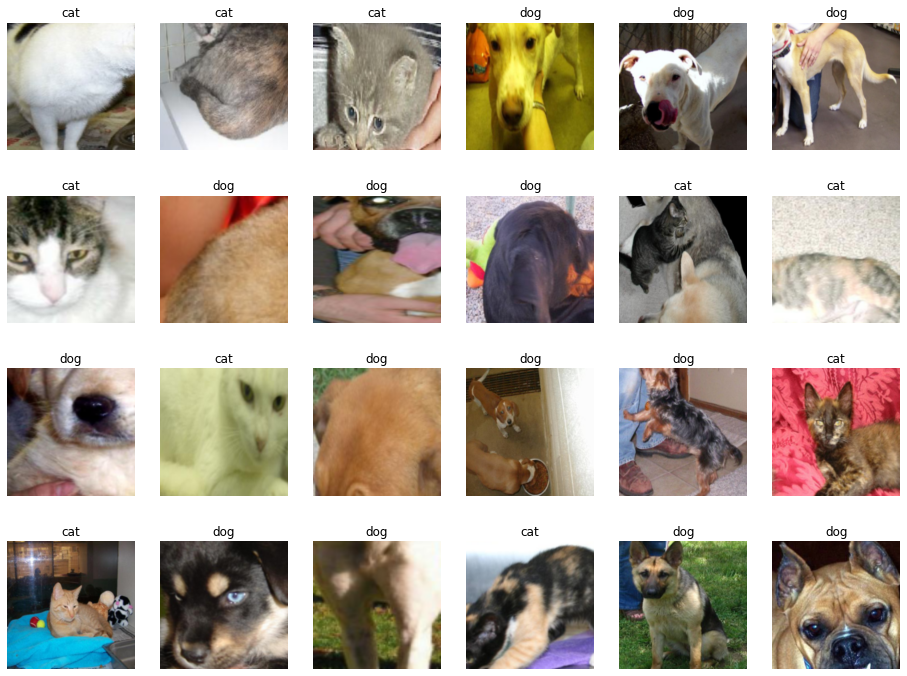

In [15]:
samples,labels = iter(train_loader).next()
classes = {0:'cat',1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a=fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(),(1,2,0)))
plt.subplots_adjust(bottom=0.2,top=0.6,hspace=0)

In [16]:
resnet18 = models.resnet18(pretrained=True)
#resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

C:\Users\user\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


사전 훈련된 모델을 가져와서 ,FC layer만 훈련시키기 위해 나머지 parameter를 훈련에서 제외시키기 위해 아래 함수를 정의함.

In [17]:
def set_parameter_requires_grad(model,feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad=False
set_parameter_requires_grad(resnet18)

fc layer를 추가한다.

In [18]:
resnet18.fc = nn.Linear(512,2)

In [19]:
for name,param in resnet18.named_parameters():
    if param.requires_grad:
        print(name,param.data)

fc.weight tensor([[ 0.0025, -0.0017, -0.0157,  ...,  0.0405,  0.0119, -0.0083],
        [-0.0423,  0.0267, -0.0157,  ...,  0.0044, -0.0409,  0.0091]])
fc.bias tensor([-0.0116, -0.0294])


In [20]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
model.fc = torch.nn.Linear(512,2)
for param in model.fc.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(model.fc.parameters())
cost= torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
def train_model(model,dataloaders,criterion,optimizer,device,num_epochs=50,is_train=True):
    since =time.time()
    acc_history=[]
    loss_history=[]
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch{}/{}'.format(epoch,num_epochs-1))
        print('-'*10)

        running_loss=0.0
        running_corrects=0

        for inputs,labels in dataloaders:
            inputs = inputs.to(device) # device 에 적재
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            _,preds = torch.max(outputs,1) #예측 결과가 최대인 index도 반환시킴. 첫번재 반환값이 value, 두번째가 indexes
            loss.backward()
            optimizer.step()

            running_loss+= loss.item()*inputs.size(0) #여기 이해가 잘 안됨.
            running_corrects+=torch.sum(preds==labels.data) # label과 index가 같은지 확인

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss:{:.4f} Acc:{:.4f}'.format(epoch_loss,epoch_acc))

        if epoch_acc>best_acc:
            best_acc=epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(),os.path.join('./dl_pytorch/chap05/data/catanddog','{0:0=2d}.pth'.format(epoch))) #epoch마다 모델을 저장한다(정확하게는 모델 파라미터를 저장함)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best Acc:{:4f}'.format(best_acc))
    return acc_history,loss_history

In [22]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
optimizer = torch.optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18,train_loader,criterion,optimizer,device)

Epoch0/49
----------
Loss:0.5647 Acc:0.7143

Epoch1/49
----------
Loss:0.3899 Acc:0.8260

Epoch2/49
----------
Loss:0.3559 Acc:0.8597

Epoch3/49
----------
Loss:0.2669 Acc:0.8987

Epoch4/49
----------
Loss:0.2601 Acc:0.8961

Epoch5/49
----------
Loss:0.2574 Acc:0.9065

Epoch6/49
----------
Loss:0.2363 Acc:0.9039

Epoch7/49
----------
Loss:0.2530 Acc:0.8753

Epoch8/49
----------
Loss:0.2741 Acc:0.8805

Epoch9/49
----------
Loss:0.2398 Acc:0.8987

Epoch10/49
----------
Loss:0.2355 Acc:0.8961

Epoch11/49
----------
Loss:0.2122 Acc:0.9195

Epoch12/49
----------
Loss:0.2868 Acc:0.8961

Epoch13/49
----------
Loss:0.2062 Acc:0.9169

Epoch14/49
----------
Loss:0.1649 Acc:0.9247

Epoch15/49
----------
Loss:0.2267 Acc:0.9117

Epoch16/49
----------
Loss:0.1699 Acc:0.9351

Epoch17/49
----------
Loss:0.1864 Acc:0.9273

Epoch18/49
----------
Loss:0.2583 Acc:0.8831

Epoch19/49
----------
Loss:0.1938 Acc:0.9117

Epoch20/49
----------
Loss:0.1972 Acc:0.9169

Epoch21/49
----------
Loss:0.2063 Acc:0.9195

In [24]:
test_path = './dl_pytorch/chap05/data/catanddog/test'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
test_dataset = torchvision.datasets.ImageFolder(root=test_path,transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,num_workers=1,shuffle=True)
print(len(test_dataset))

98


In [25]:
def eval_model(model,dataloaders,device):
    since = time.time()
    acc_history=[]
    best_acc=0.0

    saved_models = glob.glob('./dl_pytorch/chap05/data/catanddog/'+'*.pth') # 저장한 모델을 불러온다.
    saved_models.sort()
    print('saved_model',saved_models)

    for model_path in saved_models:
        print('Loading model',model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects=0
        for inputs,labels in dataloaders:
            inputs=inputs.to(device)
            labels=labels.to(device)

            with torch.no_grad(): #autograd 사용 안함
                outputs=model(inputs)
            _,preds = torch.max(outputs.data,1) #max value 인덱스 가져옴
            preds[preds>=0.5]=1
            preds[preds<0.5]=0
            running_corrects+=preds.eq(labels).int().sum() #맞게 prediction 한 애들 개수 합

        epoch_acc = running_corrects.double()/len(dataloaders.dataset)
        print('Acc:{:.4f}'.format(epoch_acc))

        if epoch_acc>best_acc:
            best_acc=epoch_acc
        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time()-since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best Acc:{:.4f}'.format(best_acc))

    return acc_history

In [26]:
val_acc_history = eval_model(resnet18,test_loader,device)

saved_model ['./dl_pytorch/chap05/data/catanddog\\00.pth', './dl_pytorch/chap05/data/catanddog\\01.pth', './dl_pytorch/chap05/data/catanddog\\02.pth', './dl_pytorch/chap05/data/catanddog\\03.pth', './dl_pytorch/chap05/data/catanddog\\04.pth', './dl_pytorch/chap05/data/catanddog\\05.pth', './dl_pytorch/chap05/data/catanddog\\06.pth', './dl_pytorch/chap05/data/catanddog\\07.pth', './dl_pytorch/chap05/data/catanddog\\08.pth', './dl_pytorch/chap05/data/catanddog\\09.pth', './dl_pytorch/chap05/data/catanddog\\10.pth', './dl_pytorch/chap05/data/catanddog\\11.pth', './dl_pytorch/chap05/data/catanddog\\12.pth', './dl_pytorch/chap05/data/catanddog\\13.pth', './dl_pytorch/chap05/data/catanddog\\14.pth', './dl_pytorch/chap05/data/catanddog\\15.pth', './dl_pytorch/chap05/data/catanddog\\16.pth', './dl_pytorch/chap05/data/catanddog\\17.pth', './dl_pytorch/chap05/data/catanddog\\18.pth', './dl_pytorch/chap05/data/catanddog\\19.pth', './dl_pytorch/chap05/data/catanddog\\20.pth', './dl_pytorch/chap05/

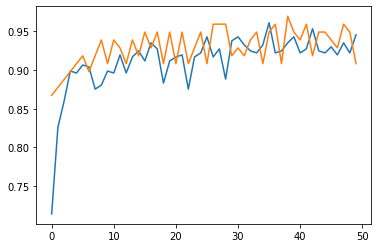

In [27]:
plt.plot(train_acc_hist)
plt.plot(val_acc_history)
plt.show()

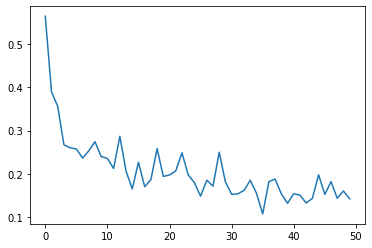

In [28]:
plt.plot(train_loss_hist)
plt.show()

In [33]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # clone ->기존 텐서 복사 생성, detatch->기울기 전파하지 않는 텐서
    #새롭개 복사한 텐서가 기울기에 영향을 주지 않더록(계산 그래프에 상주하지 않도록)
    image = image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image = image.clip(0,1)
    return image


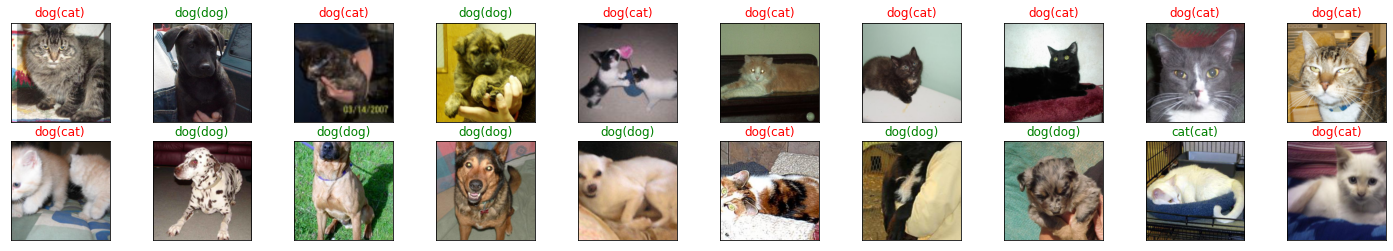

<Figure size 432x288 with 0 Axes>

In [34]:
classes ={0:'cat',1:'dog'}
dataiter = iter(test_loader)
images,labels = dataiter.next()
output=model(images) ## 훈련시킨 모델로 이미지 분류 예측
_,preds = torch.max(output,1) # 예측값 라벨 추출

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[]) #틱 삭제(눈금)
    plt.imshow(im_convert(images[idx])) # 앞서 정의한 함수를 이용해 이미지 plot
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red")) #예측 결과와 실제 레이블이 맞으면 초록, 아니면 빨강.
plt.show()
plt.subplots_adjust(bottom=0.2,top=0.6,hspace=0)

In [62]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
class XAI(nn.Module):
    def __init__(self,num_classes=2):
        super(XAI,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64,64,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(64,128,kernel_size=3,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128,128,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(128,256,kernel_size=3,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256,256,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256,256,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(256,512,kernel_size=3,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(512,512,kernel_size=3,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.classifier = nn.Sequential(
        nn.Linear(512,512,bias=False),
        nn.Dropout(0.5),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512,num_classes)
        )
    def forward(self,x):
        x=self.features(x)
        x=x.view(-1,512)
        x=self.classifier(x)
        return F.log_softmax(x)


In [64]:
model =XAI()
model.to(device)
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): MaxP

In [91]:
class LayerActivations:
    features=[]
    def __init__(self,model,layer_num):
       self.hook = model[layer_num].register_forward_hook(self.hook_fn) # 해당 layer의 정보 가져올 수 있음

    def hook_fn(self,module,input,output):
        self.features = output.detach().cpu().numpy()

    def remove(self):
        self.hook.remove()

torch.Size([1, 3, 100, 100])


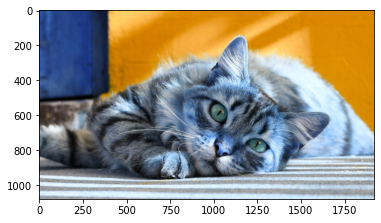

In [92]:
img = cv2.imread('./dl_pytorch/chap05/data/cat.jpg')
plt.imshow(img)
img = cv2.resize(img,(100,100),interpolation=cv2.INTER_LINEAR) ## 이미지 크기 변경, 선형보간 사용
img = ToTensor()(img).to(device).unsqueeze(0) #img->tensor->1차원 데이터로 변경(unsqueeze)
print(img.shape)

In [93]:
result = LayerActivations(model.features,0) # 0번째 layer 특성맵 확인
model(img)
activations = result.features

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

IndexError: list index out of range

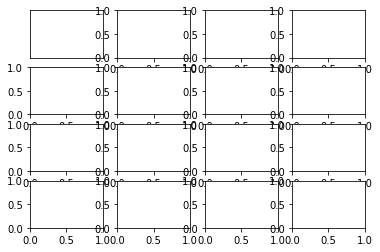

<Figure size 864x576 with 0 Axes>

In [71]:
fig,axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()